In [138]:
data_dir = '../csv_output_with_phases'  # Replace with your directory

## Loading Data 
**Column features** 
1. ```collection_id``` : collection id from the file name 
2. ```elapsed_time``` : elapsed time from the first timestep per each collection_id 
    - used to keep the order of collection id in the next processing steps ( preprocessing and building lagged dataset )
3. Sensor Data : 
    - ```gyroscope_x``` : gyroscope x-axis
    - ```gyroscope_y``` : gyroscope y-axis
    - ```gyroscope_z``` : gyroscope z-axis
    - ```accelerometer_x``` : accelerometer x-axis
    - ```accelerometer_y``` : accelerometer y-axis
    - ```accelerometer_z``` : accelerometer z-axis
9. Target Label : 
    - ```phase``` : phase of the gait event


In [139]:
######################################################
#   Loading Data                                     #
######################################################

import os
import pandas as pd
import numpy as np

def load_data_from_files(data_dir):
    all_data = []
    for filename in os.listdir(data_dir):
        if filename.endswith('.csv'):
            # Extract metadata from filename
            collection_id, step_info, _ = filename.split('_', 2)
            step_number = ''.join(filter(str.isdigit, step_info))
            foot = 'R' if 'R' in step_info else 'L'
            filepath = os.path.join(data_dir, filename)

            df = pd.read_csv(filepath)

            df['collection_id'] = collection_id + '_' + str(step_number) + '_' + foot
            df['time'] = pd.to_datetime(df['time'])
            df['elapsed_time'] = (df['time'] - df['time'].min()).dt.total_seconds()
            cols = ['collection_id', 'elapsed_time', 'gyroscope_x', 'gyroscope_y',
                    'gyroscope_z', 'accelerometer_x', 'accelerometer_y', 'accelerometer_z', 'phase']
            df = df[cols]
            all_data.append(df)
    return pd.concat(all_data, ignore_index=True)

data = load_data_from_files(data_dir)

In [140]:
data.head()

,collection_id,elapsed_time,gyroscope_x,gyroscope_y,gyroscope_z,accelerometer_x,accelerometer_y,accelerometer_z,phase
0,vh92aaJeQLxDazem2hN5_6_L,0.000,168.63,-158.62,-113.82,-1.026752,2.276032,-8.625400,1
1,vh92aaJeQLxDazem2hN5_6_L,0.005,-71.89,-272.58,-129.92,-2.516616,-1.586000,-2.127680,1
2,vh92aaJeQLxDazem2hN5_6_L,0.010,-129.85,-334.53,-114.10,-0.890112,-0.234240,0.258640,1
3,vh92aaJeQLxDazem2hN5_6_L,0.015,-206.85,-334.60,-111.30,-0.842288,0.425048,-1.624064,1
4,vh92aaJeQLxDazem2hN5_6_L,0.020,-223.65,-354.62,-105.70,0.108824,0.293288,-1.969568,1


## Preprocessing Data 

1. Define features and target 
2. Drop rows with missing values 
3. Drop rows with no event (phase = 0)
3. Subtract the phase by 1
    - XGboost takes a target value from 0 ~ (num_class-1)
4. Normalize features 
5. Encode target labels 


In [141]:
######################################################
#   Preprocessing Data                               #
######################################################

import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

def preprocess_data(data):
    # Define features and target
    features = [
        'gyroscope_x', 'gyroscope_y', 'gyroscope_z',
        'accelerometer_x', 'accelerometer_y', 'accelerometer_z'
    ]
    target = 'phase'

    # Drop rows with missing values
    data = data.dropna(subset=features + [target])

    # Drop rows with no event
    data = data[data[target] != 0]

    # Subtract the phase by 1 : XGboost takes a value from 0 ~ (num_class-1)
    data[target] = data[target] - 1

    # Normalize features
    scaler = MinMaxScaler()
    data.loc[:, features] = scaler.fit_transform(data[features])

    # Encode target labels
    label_encoder = LabelEncoder()
    data.loc[:, target] = label_encoder.fit_transform(data[target])

    return data, label_encoder

scaled_data, label_encoder = preprocess_data(data)

In [142]:
scaled_data.head()

,collection_id,elapsed_time,gyroscope_x,gyroscope_y,gyroscope_z,accelerometer_x,accelerometer_y,accelerometer_z,phase
0,vh92aaJeQLxDazem2hN5_6_L,0.000,0.691635,0.489820,0.233674,0.414113,0.588787,0.219917,0
1,vh92aaJeQLxDazem2hN5_6_L,0.005,0.498991,0.405266,0.212696,0.335429,0.371178,0.471328,0
2,vh92aaJeQLxDazem2hN5_6_L,0.010,0.452568,0.359302,0.233309,0.421329,0.447344,0.563660,0
3,vh92aaJeQLxDazem2hN5_6_L,0.015,0.390895,0.359250,0.236957,0.423855,0.484492,0.490814,0
4,vh92aaJeQLxDazem2hN5_6_L,0.020,0.377439,0.344396,0.244254,0.474086,0.477068,0.477446,0


In [143]:
np.unique(scaled_data['phase'])

array([0, 1, 2, 3])

## Computing the lag size using ACF (Autocorrelation Analysis) 
**Purpose**  
- ACF is a good start to determine if the data is stationary or non-stationary. 
    - stationary : the mean and variance of the data are constant over time. 
    - non-stationary : the mean and variance of the data are not constant over time. 
- Autocorrelation function(ACF) measures the temporal correlation of the target values to $t$ steps(lag).   
- By determining the time steps to which the target values are correlated, the number of time steps to consider to build a lagged dataset is determined.   
   
     <div style="text-align: left;">
         <img src="https://wikidocs.net/images/page/205414/정상성과비정상성.png" alt="정상성과비정상성" style="width: 80%;">
     </div>

**Steps**
1. Compute the ACF values for each collection id 
2. Compute the cutoff lag for each collection id 
3. Compute the average cutoff lag across all collection ids 
4. Round the average cutoff lag to the nearest integer 
5. Return the rounded average cutoff lag 

**Output**
- average lag size used to build a lagged dataset, which was built based on each collection id 

In [144]:
######################################################
#   Computing the lag size using ACF                 #
######################################################

from statsmodels.tsa.stattools import acf
from joblib import Parallel, delayed
import numpy as np

def compute_cutoff_lag(target, nlags=50):
    """Compute cutoff lag for a single time series."""
    acf_values, confint = acf(target, alpha=0.05, nlags=nlags)
    # confidential interval
    lower_bound = confint[1:, 0] - acf_values[1:]
    upper_bound = confint[1:, 1] - acf_values[1:]
    cutoff_lag = np.where((acf_values[1:] < lower_bound) | (acf_values[1:] > upper_bound))[0]
    if len(cutoff_lag) > 0:
        return cutoff_lag[-1] + 1  # Adjust index to match lag
    return 0

def get_lag_size(data, nlags=50):
    """Compute average cutoff lag across all collection IDs."""
    collection_ids = data['collection_id'].unique()

    # Compute cut_off lags in parallel
    cutoff_lags = Parallel(n_jobs=-1)(
        delayed(compute_cutoff_lag)(
            data[data['collection_id'] == collection_id]['phase'], nlags
        ) for collection_id in collection_ids
    )

    lag_size = round(np.mean(cutoff_lags))
    print(f'average lag_size: {lag_size}')
    return lag_size

lag_size = get_lag_size(scaled_data)

average lag_size: 19


#### **Example ACF Plot for one collection id**  

**Plot Explanation**
- y-axis : Autocorrelation of the target values
- x-axis : Lag
- Blue region : 95% confidence interval of the correlation of the target values
    - The points that lie outside of the blue region shows the statistically significant correlation. ( non-stationary $\Leftrightarrow$ data are autocorrelated )
- Cut-off point : The lag at which the ACF curve crosses the blue line
- Lag size : The lag at which the ACF curve crosses the blue line

**Plot Observation**
- The data is non-stationary, as the dots de
- The dots cross the blue line at lag 20, which is the lag size calculated by this collection data.

**ACF values are calculated as follows** 
  
  
  
-  $ACF(k) = \frac{\sum_{t=k+1}^n (y_t - \bar{y})(y_{t-k} - \bar{y})}{\sum_{t=1}^n (y_t - \bar{y})^2}$  

    - $ \bar{y} = \frac{1}{n} \sum_{t=1}^n y_t $, 
  
    - $ \text{Var}(Y_t) = \frac{1}{n} \sum_{t=1}^n (y_t - \bar{y})^2$,  $( k = \text{lag}, t = \text{time step} )$   
      
    - $ \text{Cov}(Y_t, Y_{t-k}) = \frac{1}{n-k} \sum_{t=k+1}^n (y_t - \bar{y})(y_{t-k} - \bar{y}) $       

**Confidential Interval(Blue Region) is calculated as follows** 

- $SE = \sqrt{\frac{1 + 2 \sum_{j=1}^{k-1} \rho(j)^2}{n}}$, ( $\rho(j)$ : ACF values at lag $j$, $k$ : lag, $n$ : number of data )  
- $CI = \pm 1.96 \cdot SE$
    - As lag k increases, ACF values are calculated using fewer data points (n−k), increasing the standard error of the confidence interval. 
    - Additionally, cumulative past correlations reduce data independence, further widening the confidence interval at higher lags.


<Figure size 1000x600 with 0 Axes>

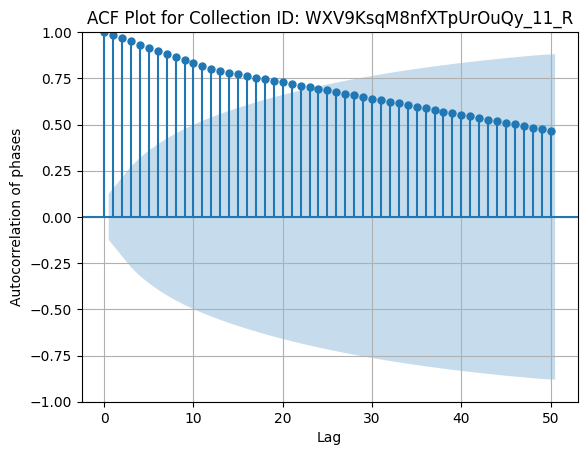

In [145]:
######################################################
#   Plotting ACF example                             #
######################################################

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# ACF example plot for one random collection id
def plot_acf_example(data):
    random_collection_id = np.random.choice(data['collection_id'].unique(), 1, replace=False)
    phase = data[data['collection_id'] == random_collection_id[0]]['phase']

    plt.figure(figsize=(10, 6))
    plot_acf(phase, lags=50)
    plt.title(f'ACF Plot for Collection ID: {random_collection_id[0]}')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation of phases')
    plt.grid(True)
    plt.show()

plot_acf_example(scaled_data)

## Plotting phase distribution per collection id 
**Purpose**
- The target values(phases) are imbalanced, especially with the small number of heel strike(phase 0).   
- Because of this imbalance, lagged datset for some collection IDs may not have heel strike(phase 0) values after dropping rows with nan values. 
- Thus, this plot is to identify collection IDs with the small number of heel strike(phase 0) values. 


**Plot Axis**
- x-axis : collection id
- y-axis : count of each phase

**Plot Observation**
- As one can see in the plot and the table below, some collection IDs have very few phase 0(heel strike).    


Sidenote : When using the [LeaveOneGroupOut](https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.LeaveOneGroupOut.html) method, errors occurred due to collection IDs without phase 0, so this plot was used to verify the problem.


                           heel strike  foot flat  heel off  toe off
collection_id                                                       
033nuFnKoOjj4NeIt9FS_10_R           21         81        50       80
033nuFnKoOjj4NeIt9FS_11_L           25         84        45       84
033nuFnKoOjj4NeIt9FS_12_R           17         95        43       88
033nuFnKoOjj4NeIt9FS_13_L           24         72        82       67
033nuFnKoOjj4NeIt9FS_3_L            23         76        42       87
...                                ...        ...       ...      ...
zmCkqhYTl03DYdauXAtc_5_R            19         92        29       85
zmCkqhYTl03DYdauXAtc_6_L            22         90        28       85
zmCkqhYTl03DYdauXAtc_7_R            26         82        32       84
zmCkqhYTl03DYdauXAtc_8_L            21         57        64       77
zmCkqhYTl03DYdauXAtc_9_R            26         80        29       84

[2324 rows x 4 columns]


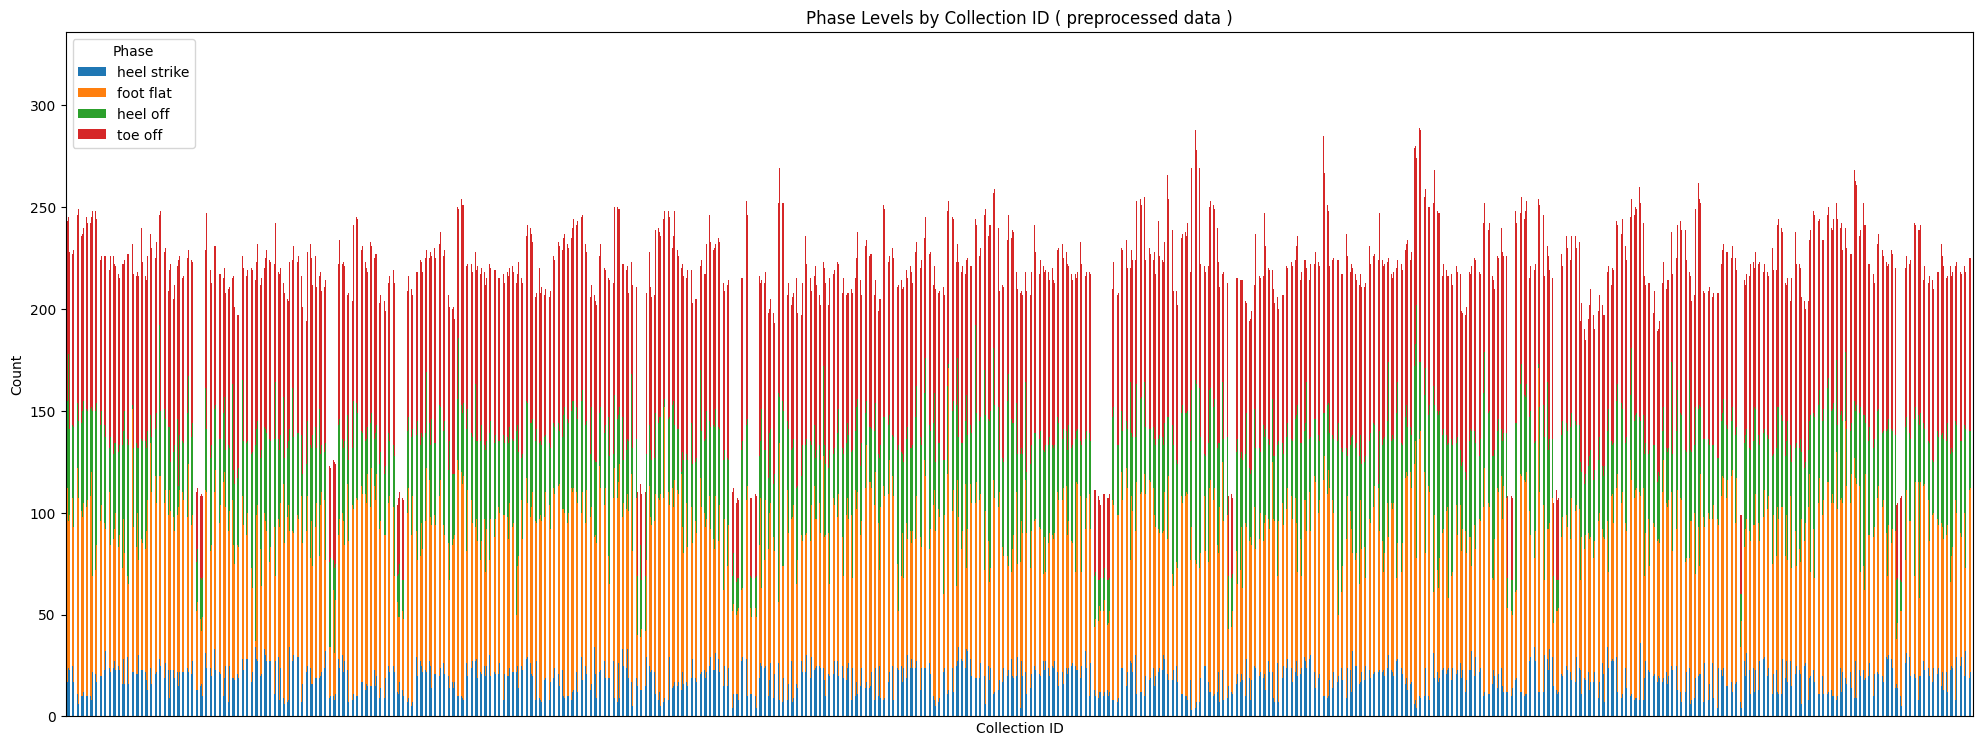

In [146]:
######################################################
#   Plotting phase distribution per collection id    #
######################################################

def plot_phase_levels(data):
    """Plot phase levels by collection ID with class names."""
    class_names = ['heel strike', 'foot flat', 'heel off', 'toe off']

    # crosstab 결과에서 컬럼 이름을 class_names로 변경
    phase_levels = pd.crosstab(data['collection_id'], data['phase'])
    phase_levels.columns = [class_names[col] for col in phase_levels.columns]  # 숫자 대신 class_names로 변경
    print(phase_levels)

    phase_levels.plot(kind='bar', stacked=True, figsize=(20, 10))

    plt.title('Phase Levels by Collection ID ( preprocessed data )')
    plt.xlabel('Collection ID')
    plt.ylabel('Count')
    plt.legend(title='Phase')
    plt.tight_layout()  # 그래프 요소가 겹치지 않도록 자동 조정
    plt.xticks([])
    plt.show()

# Call the function with scaled_data
plot_phase_levels(scaled_data)

## Building Customized Lagged DataSet 
Since data with different collection IDs are independent from each other(measured independently), the best approach would be to make a dataset that can be handled by collection id.   

**Steps** 
1. Datasets are sorted in the order of elapsed time to take into consideration the temporal correlation of the data. 
  
2. For each collection id, create a dataset with lagged features using the lag size calculated by ACF, while keeping the time order   ( function: ```make_dataset``` )
    - Each sensor feature is lagged by the lag size(19) calculated by ACF. 
    - accelerometer_x_lag1 ~ 19, accelerometer_y_lag1 ~ 19, accelerometer_x_lag1~19 
    - gyroscope_x_lag1 ~ 19, gyroscope_y_lag1 ~ 19, gyroscope_x_lag1~19
    - Total features : 19 * 6 = 114 
3. If the dataset per each collection id does not contain phase 0, add augmented data in the first rows of the current collection dataset. ( function: ```generate_augmented_zero_phase_data``` )
  
    Some considerations include :
    
    - Augmented data should be similar to other lagged features with phase 0 from other collection ids. 
    - The order of the values should be taken into consideration.
    - The generated augmented data should have a similar length to the other lagged features with phase 0 from other collection ids. 
        
    To achieve this, augmented data is generated, while keeping the order of the dataset, 
    - by using the distribution of other lagged features with phase 0 from other data with different collection ids
    - by using the last row of the lagged features of the current collection, if there is no other lagged features with phase 0 from other collection ids
    - The length of the augmented data is between the minimum and maximum length of the other lagged features with phase 0 from other collection ids 
    - If there is no other lagged features with phase 0 from other collection ids, the length is fixed to 2 

    Consequently,
    - Each feature of the augmented data is from the normal distribution $\mathbb{N}(\mu_{\text{feature i}}, \sigma_{\text{feature i}}$) of other lagged features with phase 0 from other collection ids.
    - All the datasets per each collection id contain at least 2 rows with phase 0 
    - With the function ```check_phase_zero_data```, one can check if all the datasets per each collection id contain phase 0 

    
3. Concatenate all the datasets keeping the order of the dataset and create a final dataset with new indice ( pd.concat( ., ignore_index=True) enables it.  )  
  
  
**Variables** 
- inspection purpose features :
    - ```self.X_df``` : dataframe with lagged features
    - ```self.y_df``` : dataframe with target values
    - ```self.collection_ids_df``` : dataframe with collection ids
- train purpose features :
    - ```self.X``` : numpy array of dataset with lagged features
    - ```self.y``` : numpy array of target values
    - ```self.collection_ids``` : numpy array of collection ids 
- features to keep the original dataset :
    - ```self.original_X_df``` : original dataset with lagged features
    - ```self.original_y_df``` : original target values
    - ```self.original_collection_ids_df``` : original collection ids  
  
**Customized ```__getitem__``` method**   
- To easily manipulate the dataset by collection id, ```__getitem__``` function works by collection ids. 
    - ```dataset[:100]``` : returns data associated with the first 100 collection ids
    - ```dataset[1]``` : returns data associated with the first collection id
    - ```dataset.reset()``` : resets the dataset to the original dataset 
- This enables to use a subset of the dataset for training and validation, easily without having to create a new dataset.  
  
**data** 
- self.X_df : Since the calculated lag size is 19, the number of lagged fueatures used for training is 19 * 6  
    - accelerometer_x_lag1 ~ 19, accelerometer_y_lag1 ~ 19, accelerometer_x_lag1~19 
    - gyroscope_x_lag1 ~ 19, gyroscope_y_lag1 ~ 19, gyroscope_x_lag1~19 
- self.y_df contains : 
    - the labels of the lagged features 
- self.collection_ids_df contains : 
    - the original collection id of the lagged features 

**reference**   
- [XGBoost Add Lagged Input Variables for TIme Series Forecasting](https://xgboosting.com/xgboost-add-lagged-input-variables-for-time-series-forecasting/) 

In [209]:
######################################################
#   Building Customized Lagged DataSet               #
######################################################

import random

class Lagged_DataSet():
    def __init__(self, data, features, target, lag_size=30):
        self.data = data
        self.features = features
        self.target = target
        self.lag_size = lag_size
        self.lagged_feature_names = []

        self.X_df = pd.DataFrame()
        self.y_df = pd.DataFrame()
        self.collection_ids_df = pd.DataFrame()

        self.original_X_df = pd.DataFrame()
        self.original_y_df = pd.DataFrame()
        self.original_collection_ids_df = pd.DataFrame()

        self.X = pd.DataFrame()
        self.y = pd.DataFrame()
        self.collection_ids = []

        self.make_dataset()
        self.check_phase_zero_data()


    def make_dataset(self):
        X_df = pd.DataFrame()
        y_df = pd.DataFrame()
        collection_ids_df = pd.DataFrame()

        len_features = len(self.features)

        for collection_id in self.data['collection_id'].unique():
            collection_data = self.data[self.data['collection_id'] == collection_id].sort_values(by='elapsed_time')
            collection_data = collection_data[self.features + self.target + ['collection_id']]
            collection_length = len(collection_data)

            if collection_length > self.lag_size:
                lagged_features = {}
                for j in range(len_features):
                    for i in range(1, self.lag_size+1):
                        lagged_features[f'{self.features[j]}_lag{i}'] = collection_data[self.features[j]].shift(i)
                lagged_df = pd.DataFrame(lagged_features)
                self.lagged_feature_names = list(lagged_df.columns)
                collection_data = pd.concat([collection_data, lagged_df], axis=1)

            collection_data.dropna(inplace=True)
            collection_data['collection_id'] = collection_id

            collection_data = collection_data.drop(columns=self.features) # leave only the lagged features and collection id
            collection_data = collection_data.dropna(axis=1, how='any') # drop non values

            # if current collection data with lagged features don't contain phase 0, add augmented data
            if not (0 in collection_data[collection_data['collection_id'] == collection_id]['phase'].unique()):
                # support data is used when there is no collection data with phase 0 yet 
                support_data = collection_data[self.lagged_feature_names].iloc[:2]  # adjust the number of rows to be used from the current collection data
                augmented_data = self.generate_augmented_zero_phase_data(support_data)

                df = pd.DataFrame(augmented_data, columns=self.lagged_feature_names)
                df['phase'] = [0] * len(augmented_data)
                df['collection_id'] = [collection_id] * len(augmented_data)
                collection_data = pd.concat([df, collection_data], ignore_index=True).reset_index(drop=True)

            X_df = pd.concat([X_df, collection_data.drop(columns=self.target + ['collection_id'])], ignore_index=True)
            y_df = pd.concat([y_df, collection_data[self.target]], ignore_index=True)
            collection_ids_df = pd.concat([collection_ids_df, collection_data.drop(columns=self.target + self.lagged_feature_names)], ignore_index=True)

        self.X_df = X_df.copy()
        self.y_df = y_df.copy()
        self.collection_ids_df = collection_ids_df.copy()

        self.original_X_df = self.X_df.copy()
        self.original_y_df = self.y_df.copy()
        self.original_collection_ids_df = self.collection_ids_df.copy()

        self.X = self.X_df.values
        self.y = self.y_df.values
        self.collection_ids = self.collection_ids_df.values

    # generate augmented data for the current collection data, if the current collection data does not contain phase 0
    def generate_augmented_zero_phase_data(self, support_data=None):
        features_with_zero_phase_list = []

        # Get features values for phase 0 from collection data that have phase 0
        if len(self.collection_ids_df) > 0:
            for id in self.collection_ids_df['collection_id'].unique():
                id_mask = self.collection_ids_df['collection_id'] == id
                zero_mask = self.y_df[id_mask]['phase'] == 0
                features_with_zero_phase = self.X_df[zero_mask]

                if not (len(features_with_zero_phase) == 0): # if features have zero phase values, add the current data to a list
                    features_with_zero_phase_list.append(features_with_zero_phase.values)

                datasets = [np.array(data) for data in features_with_zero_phase_list]
        # Get feature values from the first two rows of the current collection data     
        else:
            datasets = [[np.array(data) for data in support_data.values]]  # datasets shape = [ [id_1_list_1, id_1_list_2, ... ], [id_2_list_1, id_2_list_2, ...], ... ]

        # Get a random length for the augmented data between the maximum and minimum length of the datasets
        max_length = max(len(data) for data in datasets)
        min_length = min(len(data) for data in datasets)
        output_length = random.randint(min_length, max_length) # pick a random length among datasets per collection id

        new_data = [] # list for generated augmented data
        for idx in range(output_length):
            rows = [] # list for sample data(existing data) to be used to generate augmented data
            for data in datasets:
                if idx < len(data):
                    rows.append(data[idx])
                else: # output length is chosen randomly, among all the data. some data might have less length than output length. Thus use the data in the current data
                    rows.append(np.random.normal(np.mean(data[-1]), np.std(data[-1]), size=data.shape[1])) # generate similar values similar to the last row of the data following normal dist

            combined_rows = np.vstack(rows)
            mean_per_feature = np.mean(combined_rows, axis=0) # calculate the mean values per feature
            std_per_feature = np.std(combined_rows, axis=0) # calculate the standard deviation per feature

            new_rows = [np.random.normal(mean_per_feature, std_per_feature)] # generate augmented data based on the mean and std of the existing feature values for phase 0 
            new_data.extend(new_rows)

        return new_data 

    # function to check if all the datasets per each collection id contain all phase values 
    def check_phase_zero_data(self):
        phase_values = {0, 1, 2, 3}
        missing_phase_ids = []

        for id in self.collection_ids_df['collection_id'].unique():
            id_mask = self.collection_ids_df['collection_id'] == id
            y_phase_values = self.y_df[id_mask]['phase']
            if not phase_values.issubset(set(y_phase_values)):
                missing_phase_ids.append(id)

        if missing_phase_ids:
            print(f'The following collection IDs do not contain all phase values: {missing_phase_ids}')
        else:
            print('All collection IDs contain all phase values')


    def __len__(self):
        return len(self.X)

    # retuns data for (idx) group. Supports slicing and indexing based on collection id
    def __getitem__(self, idx):
        self.reset()
        if isinstance(idx, slice):
            target_ids = self.original_collection_ids_df['collection_id'].unique()[idx]
        else:
            target_ids = [self.original_collection_ids_df['collection_id'].unique()[idx]]

        mask = self.original_collection_ids_df['collection_id'].isin(target_ids)

        self.X_df = self.original_X_df[mask].reset_index(drop=True)
        self.y_df = self.original_y_df[mask].reset_index(drop=True)
        self.collection_ids_df = self.original_collection_ids_df[mask].reset_index(drop=True)

        self.X = self.X_df.values
        self.y = self.y_df.values
        self.collection_ids = self.collection_ids_df.values

        return self
    
    # return the original dataset when instance is called after Lagged_DataSet.__getitem__() is called 
    def __call__(self):
        return self.reset()

    def reset(self):
        """원본 데이터를 기반으로 현재 데이터 초기화"""
        self.X_df = self.original_X_df
        self.y_df = self.original_y_df
        self.collection_ids_df = self.original_collection_ids_df

        self.X = self.X_df.values
        self.y = self.y_df.values
        self.collection_ids = self.collection_ids_df.values


features = ['gyroscope_x', 'gyroscope_y', 'gyroscope_z',
            'accelerometer_x', 'accelerometer_y', 'accelerometer_z']
target = ['phase']
dataset = Lagged_DataSet(scaled_data, features, target, lag_size)

All collection IDs contain all phase values


In [159]:
print(f'dataset[:100] length : {len(dataset[:100])}')
print(f'dataset length : {len(dataset)}')
dataset.reset()
print(f'dataset length after dataset.reset() : {len(dataset)}')

dataset[:100] length : 20016
dataset length : 20016
dataset length after dataset.reset() : 464590


In [160]:
dataset.X_df.head()

,gyroscope_x_lag1,gyroscope_x_lag2,gyroscope_x_lag3,gyroscope_x_lag4,gyroscope_x_lag5,gyroscope_x_lag6,gyroscope_x_lag7,gyroscope_x_lag8,gyroscope_x_lag9,gyroscope_x_lag10,...,accelerometer_z_lag10,accelerometer_z_lag11,accelerometer_z_lag12,accelerometer_z_lag13,accelerometer_z_lag14,accelerometer_z_lag15,accelerometer_z_lag16,accelerometer_z_lag17,accelerometer_z_lag18,accelerometer_z_lag19
0,0.573279,0.574568,0.573335,0.569859,0.565710,0.564196,0.560832,0.560327,0.565317,0.559094,...,0.469817,0.474632,0.480505,0.479674,0.474859,0.477446,0.490814,0.563660,0.471328,0.219917
1,0.568569,0.573279,0.574568,0.573335,0.569859,0.565710,0.564196,0.560832,0.560327,0.565317,...,0.467684,0.469817,0.474632,0.480505,0.479674,0.474859,0.477446,0.490814,0.563660,0.471328
2,0.573279,0.574568,0.573335,0.569859,0.565710,0.564196,0.560832,0.560327,0.565317,0.559094,...,0.469817,0.474632,0.480505,0.479674,0.474859,0.477446,0.490814,0.563660,0.471328,0.219917
3,0.568569,0.573279,0.574568,0.573335,0.569859,0.565710,0.564196,0.560832,0.560327,0.565317,...,0.467684,0.469817,0.474632,0.480505,0.479674,0.474859,0.477446,0.490814,0.563660,0.471328
4,0.565710,0.568569,0.573279,0.574568,0.573335,0.569859,0.565710,0.564196,0.560832,0.560327,...,0.467835,0.467684,0.469817,0.474632,0.480505,0.479674,0.474859,0.477446,0.490814,0.563660


In [161]:
print(dataset.X.shape, dataset.y.shape)

(464590, 114) (464590, 1)


## Training and Validating The Model
XGBoost([Original Article](http://arxiv.org/pdf/1603.02754)) is one of boosting models that is most preferred for developing predictive models because of its performance. Especially, its support for GPU and parallel computing makes it adequate to handle large complex dataset.   
- Since the gait data is collected per groups, the data is trained, validated, and tested per group. 
    - [GroupShuffleSplit](https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) is used to split the dataset into train and test set. 
    - [GroupKFold](https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.GroupKFold.html) is used for the model training and the cross validation.
    - [LeaveOneGroupOut](https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.LeaveOneGroupOut.html) can be also used for the model training and the cross validation.
        - Choosing between GroupKFold and LeaveOneGroupOut should be compromised between the computation time and the model robustness. 
            - LeaveOneGroupOut split the data into the number of groups, which guarantees that each group is used exactly once in the train and test(validation) set. However, it requires a very long computation time. 
            - GroupKFold is a more reasonable choice considering the computation time and the model robustness, as the number of splits can be customized. However, the several groups may appear in the test(validation) set, which reduces the model robustness. 

#### **Steps** 
**Data Preparation** 
1. ```get_sample_dataset```  ( optional )
    - input : Lagged_DataSet, proportion(default 0.1)
        - proportion : the proportion of the total *unique collection IDs* to be used for training.
            - Example: 1000 data, 10 unique id -> proportion = 0.3 -> data associated with 3 unique ids are returned ( the size of data is determined by the number of the data associated with 3 unique ids )
    - output : Lagged_DataSet associated with (proportion)% of the total *unique collection IDs*
    - dataset.reset() is called to reset the dataset to the original dataset before and after the sample dataset is retrieved. 
    - This is optional, but it is used to reduce the time to find approximate parameters for the model. 
        - The caveat of using a subset is that the model may have a higher bais and less variance. 
        - But this signifcantly reduces the time to find approximate parameters for the model. 
        
**Training**  

3. ```train_XGBoost_manual_grid_search```
    - input : Lagged_DataSet, xgb_param_grid
    - output : best_model, best_params, best_eval_result
        - best_model : the best model trained by XGBoost
        - best_params : the best parameters for the best model
        - best_eval_result : the evaluation result of the best model ( [evals_result()](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.Booster.evals_result)    )
    - ```get_train_test_idx```
        - input : Lagged_DataSet, test_size(default 0.2)
        - output : train_idx, test_idx 
        - [GroupShuffleSplit](https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) is used to split the dataset into train and test set
            - Splits the data into train and test set ( by setting the seed value, train and test set can be fixed. )
            - Suitable for the case where the dataset is large and test size(test proportion) needs to be explicitly set. 

    - Trains the model using ```XGBClassifier``` scikit-learn wrapper. ( refer to the links for parameter details )
      
    - Model Parameters : 
        - [The most important parameters to tune](https://xgboosting.com/most-important-xgboost-hyperparameters-to-tune/)
        - [Default parameter values](https://xgboosting.com/xgboost-default-parameters/) 
        - [Easy reference for tuning the parameters](https://s3.amazonaws.com/kajabi-storefronts-production/file-uploads/sites/2147512189/themes/2150624317/downloads/effce67-5af-085-3b57-ddefcc0fe31_Gradient_Boosting_1_.pdf) - [YouTube Link](https://www.youtube.com/watch?v=yw-E__nDkKU)
        - Observation:
            - The number of lagged features(114) is large, thus adjusting the model complexity is important to prevent overfitting. 
                - high max_depth(6~10) showed significant improvements $\rightarrow$ lower learning_rate(0.01~0.5), colsample_bytree(0.5~1), subsample(0.5~1) / higher min_child_weight(1~5) 
                - other parameters did not show significant improvements; improvements on the second decimal point level
        
      
    - [GroupKFold](https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.GroupKFold.html) is used to split the train data into train and validation set for cross validation
        - Ensures that each group(collection id) appears exactly once in the train and eval set across all folds.
        - Because of the above, the model can be better generalized and less overfit. 
        - Another option is to use [LeaveOneGroupOut](https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.LeaveOneGroupOut.html), which trains on all the groups but one. 
            - To use this option, uncomment the relevant code in the ```train_XGBoost_manual_grid_search``` function. 

    - Using GPU resources by using ```cupy``` library. 
        - Data used for training (X_train) is converted to ```cupy``` array.  
            - To use this option, uncomment the relevant code in the ```train_XGBoost_manual_grid_search``` function. 

    - Early Stopping and Sample Weight : grid search packages from Scikit-learn do not support early stopping and sample weight implementation, thus grid search should be manually implemented.
        - [XGBoost Early Stopping With Grid Search](https://xgboosting.com/xgboost-early-stopping-with-grid-search/) 
        - (Optional) [sample_weights](https://xgboosting.com/xgboost-scale_pos_weight-vs-sample_weight-for-imbalanced-classification/) parameter is used to give more weight to the minor class. However, the performance was degraded when using this.  
    
**Why using group based data split** 
- If group related instacnes appear both in training and testsets can cause data leakage, leading to overly optimistinc results. 
- The gait phases per each collection id are correlated, as observed from ACF function, thus using group based data split is more appropriate.  
- Ref : [How to Generate a Train-Split Based on Group ID?](https://www.geeksforgeeks.org/how-to-generate-a-train-test-split-based-on-a-group-id/)

  
**LeaveOneGroupOut vs GroupKFold**   
  
- When tuning the parameters, using the whole dataset(2036 groups), the total number of fit increases exponentially, thus the computation time accordingly.   
- For example, if 3\*3\*3\*3\*3 parameter combination is used along with 2036 groups, the total number of fit is 3\*3\*3\*3\*3\* **number_of_splits**. 
    - Using [LeaveOneGroupOut(LOGO)](https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.LeaveOneGroupOut.html) can help train a more generalized model, because it trains on all the groups but one. However the **number_of_splits** for LOGO is equal to the number of groups, which leads to a very long computation time.
        - Using 10% of group ids, the total number of fit is 3\*\3\*3\*3\*3\*203 = 49,329 splits, with each fit taking 1~10seconds on CUDA environment 
        - $\rightarrow$ 49,329 * 10 = 493,290 seconds $\approx$ 137 hours ( Unacceptably long computation time. )
    - Using [GroupKFold](https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.GroupKFold.html), one can control the number of splits, although the model will be less robust. 
        - Using 10% of group ids and 10 splits, the total number of fit is 3\*3\*3\*3\*3\*10 = 2430 splits, with each fit taking 1~5 seconds on CUDA environment 
        - $\rightarrow$ 2430 * 5 = 12,150 seconds $\approx$ 3.375 hours ( Acceptable computation time. )   
    
- Therefore, when there are large number of groups, using **GroupKFold** is a more reasonable choice considering the computation time and complexity. 


**Sidenote**   
- If one wants to use Scikit-learn cross validation packages, such as RandomizedSearchCV and GridSearchCV, Scikit-learn version should be less than 1.6.0 ( < 1.6.0 ). ( [StackOverFlow Link](https://stackoverflow.com/questions/79290968/super-object-has-no-attribute-sklearn-tags) )


In [162]:
######################################################
#   Training and Validating the Model                #
######################################################

from xgboost import XGBClassifier
from sklearn.model_selection import GroupKFold, GroupShuffleSplit, LeaveOneGroupOut # StratifiedGroupKFold, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, log_loss
from sklearn.utils import class_weight
import numpy as np
# import cupy as cp   # uncomment to use GPU
import itertools
import time

def get_sample_dataset(dataset, proportion=0.1):
    dataset.reset()
    total_dataset_size = len(dataset)
    collection_ids = np.unique(dataset.collection_ids)
    sample_ids_size = int(len(collection_ids) * proportion)
    sample_dataset = dataset[:sample_ids_size]
    sample_dataset_size = len(sample_dataset)
    print(f'total groups: {len(collection_ids)}, sample groups: {sample_ids_size}({proportion*100}%), total size: {total_dataset_size}, sample size: {sample_dataset_size}')
    dataset.reset()
    return sample_dataset

def get_train_test_idx(dataset, test_size=0.2):
    groups = dataset.collection_ids_df['collection_id']
    gs = GroupShuffleSplit(n_splits=2, test_size=test_size, random_state=42) # 동일한 그룹에 속한 데이터는 훈련 세트와 테스트 세트에 중복되지 않도록 보장
    train_idx, test_idx = next(gs.split(dataset.X, dataset.y, groups=groups))
    print(f'train groups: {len(np.unique(groups[train_idx]))}, test groups: {len(np.unique(groups[test_idx]))}({test_size*100}%), train size: {len(train_idx)}, test size: {len(test_idx)}')

    return train_idx, test_idx


def train_XGBoost_manual_grid_search(dataset, xgb_param_grid):
    # n_collection_dis = len(np.unique(dataset.collection_ids))

    # train dataset
    train_idx, _ = get_train_test_idx(dataset)
    X_train, y_train, train_groups = dataset.X[train_idx], dataset.y[train_idx], dataset.collection_ids[train_idx]

    # Uncomment to use GPU
    # if cp.cuda.runtime.getDeviceCount() > 0: # if gpu available, convert numpy array to cupy array
    #     X_train = cp.asarray(X_train)

    # Fold Split for GroupKFold Cross Validation
    gkf_n_splits = 10
    gkf = GroupKFold(n_splits=gkf_n_splits) 

    # Leave One Group Out Cross validation 
    # logo = LeaveOneGroupOut()
    # logo_n_splits = logo.get_n_splits(X_train, y_train, train_groups)
                                      

    # calculate the total rounds
    param_values = list(xgb_param_grid.values())
    all_combinations = list(itertools.product(*param_values))
    total_combinations = len(all_combinations)
    total_round = total_combinations * gkf_n_splits
    # total_round = total_combinations * logo_n_splits
    current_round = 1
    print(f'total rounds: {total_round} = param_combination({total_combinations}) * splits ({gkf_n_splits})')
    # print(f'total round: {total_round} = param_combination({total_combinations}) * splits ({logo_n_splits})')

    # define XGBclassifier
    xgb_clf = XGBClassifier()

    # store the best score ( accuracy ) after training the model
    best_score = 0

    # params to return 
    best_params = {}
    best_eval_result = None
    best_model = None
    for colsample_bytree in xgb_param_grid['colsample_bytree']:
        for n_estimators in xgb_param_grid['n_estimators']:
            for subsample in xgb_param_grid['subsample']:
                for min_child_weight in xgb_param_grid['min_child_weight']:
                    for max_depth in xgb_param_grid['max_depth']:
                        for learning_rate in xgb_param_grid['learning_rate']:
                            for reg_lambda in xgb_param_grid['reg_lambda']:
                                for reg_alpha in xgb_param_grid['reg_alpha']:
                                    for gamma in xgb_param_grid['gamma']:
                                        for early_stopping_rounds in xgb_param_grid['early_stopping_rounds']:
                                            print(f'current params: n_estimators:{n_estimators:}, learning_rate:{learning_rate}, max_depth:{max_depth}, subsample:{subsample}, min_child_weight:{min_child_weight}, colsample_bytree:{colsample_bytree}, reg_lambda:{reg_lambda}, reg_alpha:{reg_alpha}, gamma:{gamma}, early_stopping_rounds:{early_stopping_rounds}')

                                            # store scores(metrics) per fold
                                            train_log_loss_list = []
                                            val_accuracy_list = []
                                            val_log_loss_list = []

                                            # metric values for loss_curve 
                                            fold_train_loss_value_list = []
                                            fold_eval_loss_value_list = []
                                            avg_fold_loss_list = []

                                            # Cross validation ( GroupKFold / LeaveOneGroupOut )
                                            for i, (train_index, val_index) in enumerate(gkf.split(X_train, y_train.ravel(), train_groups.ravel())): # use groupKFold split
                                            # for i, (train_index, val_index) in enumerate(logo.split(X_train, y_train.ravel(), train_groups.ravel())): # use LeaveOneGroupOut split
                                                # print(f'train groups: {len(np.unique(train_groups[train_index]))}, val groups: {len(np.unique(train_groups[val_index]))}, train size: {len(train_index)}, val size: {len(val_index)}')
                                                start_time = time.perf_counter()

                                                X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
                                                y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
                                                eval_set = [(X_train_fold, y_train_fold), (X_val_fold, y_val_fold)]

                                                # give more weight to the minor class ( uncomment to use, but the performance was degraded when using this )
                                                # train_class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train_fold), y=y_train_fold.ravel())
                                                # train_sample_weights = np.array([train_class_weights[int(phase)] for phase in y_train_fold.ravel()])

                                                xgb_clf.set_params(
                                                    ##### Hyper Parameters tune 
                                                    colsample_bytree=colsample_bytree,
                                                    n_estimators=n_estimators,
                                                    subsample=subsample,
                                                    min_child_weight=min_child_weight,
                                                    max_depth=max_depth,
                                                    learning_rate=learning_rate,
                                                    reg_lambda=reg_lambda,
                                                    reg_alpha=reg_alpha,
                                                    gamma=gamma,
                                                    ##### Model Parameters
                                                    objective=xgb_param_grid['objective'][0],
                                                    eval_metric=xgb_param_grid['eval_metric'][0],
                                                    seed=xgb_param_grid['seed'][0],
                                                    num_class=xgb_param_grid['num_class'][0],
                                                    n_jobs=xgb_param_grid['n_jobs'][0],
                                                    early_stopping_rounds=xgb_param_grid['early_stopping_rounds'][0]
                                                )

                                                xgb_clf.fit(
                                                    X_train_fold,
                                                    y_train_fold,
                                                    eval_set=eval_set,
                                                    # sample_weight=train_sample_weights, # uncomment to use to give more weight to the minor class but performance was degraded when using this
                                                    verbose=False
                                                )

                                                # retrieve performance metrics
                                                fold_result = xgb_clf.evals_result()

                                                val_accuracy = accuracy_score(y_val_fold, xgb_clf.predict(X_val_fold))
                                                train_log_loss = log_loss(y_train_fold, xgb_clf.predict_proba(X_train_fold))
                                                val_log_loss = log_loss(y_val_fold, xgb_clf.predict_proba(X_val_fold))

                                                val_accuracy_list.append(val_accuracy)
                                                train_log_loss_list.append(train_log_loss)
                                                val_log_loss_list.append(val_log_loss)

                                                fold_train_loss_value_list.append(fold_result['validation_0']['mlogloss']) # training loss values
                                                fold_eval_loss_value_list.append(fold_result['validation_1']['mlogloss']) # eval loss values

                                                end_time = time.perf_counter()

                                                # print the current progress ( time in seconds )
                                                print(f'{current_round}/{total_round} | Fold:{i+1}/{gkf_n_splits} | val_accuracy: {val_accuracy:.6f} | train_log_loss: {train_log_loss:.6f}, val_log_loss: {val_log_loss:.6f}, time: {(end_time - start_time):.4f}')
                                                # print(f'{current_round}/{total_round} | Fold:{i+1}/{logo_n_splits} | val_accuracy: {val_accuracy:.6f} | train_log_loss: {train_log_loss:.6f}, val_log_loss: {val_log_loss:.6f}, time: {(end_time - start_time):.4f}')

                                                current_round += 1

                                            # calculate the average loss over all folds ( used to plot loss curve ); 'validation_0' is train loss, 'validation_1' is eval loss 
                                            avg_fold_loss_list = {'validation_0': [sum(values) / len(values) for values in zip(*fold_train_loss_value_list)], 
                                                                'validation_1': [sum(values) / len(values) for values in zip(*fold_eval_loss_value_list)]}

                                            # compute average score across all folds
                                            average_val_accuracy = np.mean(val_accuracy_list)

                                            # print the average loss over all folds for the current params
                                            print(f'avg_val_accuracy: {average_val_accuracy:.6f} | avg_train_loss: {np.mean(train_log_loss_list):.6f}, avg_val_loss: {np.mean(val_log_loss_list):.6f}')
                                            # Save the best model, best params, and best eval result
                                            if average_val_accuracy > best_score:
                                                best_score = average_val_accuracy
                                                best_params = {
                                                    ##### Hyper Parameters 
                                                    'learning_rate': [learning_rate],
                                                    'max_depth': [max_depth],
                                                    'min_child_weight': [min_child_weight],
                                                    'subsample': [subsample],
                                                    'colsample_bytree': [colsample_bytree],
                                                    'n_estimators': [n_estimators],
                                                    'reg_alpha': [reg_alpha],
                                                    'reg_lambda': [reg_lambda],
                                                    'gamma': [gamma],
                                                    ##### Model Parameters 
                                                    'objective': [xgb_param_grid['objective'][0]],
                                                    'eval_metric': [xgb_param_grid['eval_metric'][0]],
                                                    'seed': [xgb_param_grid['seed'][0]],
                                                    'num_class': [xgb_param_grid['num_class'][0]],
                                                    'early_stopping_rounds': [xgb_param_grid['early_stopping_rounds'][0]],
                                                    'n_jobs': [xgb_param_grid['n_jobs'][0]],
                                                    # Uncomment to use GPU
                                                    # 'tree_method': [xgb_param_grid['tree_method'][0]],
                                                    # 'device': [xgb_param_grid['device'][0]]
                                                }
                                                best_eval_result = avg_fold_loss_list
                                                best_model = xgb_clf

    print(f'Best Accuracy:{best_score:.6f}')
    print(f'Best Params:\n {best_params}')
    return best_model, best_params, best_eval_result


######################################################
#   Hyper Parameters to Tune                         #
###################################################### 

xgb_param_manual_grid = {
    ##### Hyper Parameters tune 
    'learning_rate': [0.05, 0.08, 0.1],  # default : 0.1 ( lower, less overfit )
    'max_depth': [6, 8, 10],             # default : 6 ( lower, less overfit )
    'min_child_weight': [1, 3, 5],       # default : 1 ( larger, less overfit )
    'subsample': [0.8, 1],               # default 1 ( lower, less overfit )
    'colsample_bytree': [0.8, 1],        # default 1 ( lower, less overfit )
    'n_estimators': [100, 200, 300],     # default : 100 number of trees, ( higher, the better performance - lower lr & more trees )
    'reg_alpha': [0, 1],                 # default : 0 ( L1 reg ) / 0 ~ 5
    'reg_lambda': [1, 3],                # default : 1 ( L2 reg ) / 0 ~ 5
    'gamma': [0, 1],                     # default : 0 / reducing the minimum loss reduction / 0 ~ inf 
    ##### Model parameter                
    'objective': ['multi:softmax'],
    'eval_metric': ['mlogloss'],
    'seed': [42],
    'num_class': [len(np.unique(dataset.y))],
    'n_jobs': [-1],
    'early_stopping_rounds': [10]
    # Uncomment to use GPU
    # 'tree_method': ['hist'],
    # 'device': ['cuda']
}

#### Train on a subset : find the best hyper parameter candidate.  
- Using grid search on the entire dataset(entire groups) take an acceptable time. 
- Thus, find the best hyper parameter candidate on a subset of data(a subset of unique collection ids).

In [152]:
# ######################################################
# #   Finding Hyperparameters on a Subset              #
# ######################################################

# sample_dataset = get_sample_dataset(dataset, proportion=0.1) # adjust the proportion when tuning the parameters on a smaller subsets of data 
# _, sample_best_params, _ = train_XGBoost_manual_grid_search(sample_dataset, xgb_param_manual_grid)

#### Train on the entire dataset with the best parameters found on the subset 

In [180]:
# best params found from the 10% subset 
# total groups: 2324, sample groups: 232(10.0%), total size: 464590, sample size: 46167

sample_best_params = {
    'learning_rate': [0.08],
    'max_depth': [8],
    'min_child_weight': [5],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'n_estimators': [200],
    'reg_alpha': [0],
    'reg_lambda': [1],
    'gamma': [0],
    'objective': ['multi:softmax'],
    'eval_metric': ['mlogloss'],
    'seed': [42],
    'num_class': [4],
    'early_stopping_rounds': [10],
    'n_jobs': [-1]
}

In [163]:
######################################################
#   Training on the entire dataset                   #
######################################################

whole_dataset = get_sample_dataset(dataset, proportion=1) 
final_best_model, final_best_params, final_best_eval_result = train_XGBoost_manual_grid_search(whole_dataset, sample_best_params)

total groups: 2324, sample groups: 2324(100%), total size: 464590, sample size: 464590
train groups: 1859, test groups: 465(20.0%), train size: 371290, test size: 93300
total rounds: 10 = param_combination(1) * splits (10)
current params: n_estimators:200, learning_rate:0.08, max_depth:8, subsample:0.8, min_child_weight:5, colsample_bytree:0.8, reg_lambda:1, reg_alpha:0, gamma:0, early_stopping_rounds:10
1/10 | Fold:1/10 | val_accuracy: 0.921589 | train_log_loss: 0.138994, val_log_loss: 0.188048, time: 31.8152
2/10 | Fold:2/10 | val_accuracy: 0.914564 | train_log_loss: 0.137019, val_log_loss: 0.204876, time: 50.8103
3/10 | Fold:3/10 | val_accuracy: 0.919237 | train_log_loss: 0.138226, val_log_loss: 0.195581, time: 40.6889
4/10 | Fold:4/10 | val_accuracy: 0.915295 | train_log_loss: 0.136548, val_log_loss: 0.206356, time: 40.4078
5/10 | Fold:5/10 | val_accuracy: 0.913648 | train_log_loss: 0.136563, val_log_loss: 0.203151, time: 38.6728
6/10 | Fold:6/10 | val_accuracy: 0.921618 | train_lo

## Save the models 
**Files** 
- best_model.joblib: the best model
- best_params.joblib: the best parameters
- best_eval_result.joblib: the best evaluation result  

- saved in the `model` folder

In [337]:
######################################################
#   Saving the best model and best params            #
######################################################

# save the model, params, and eval result 
import joblib
import os

def save_model(model, params, eval_result, directory='./model'):
    if not os.path.exists(directory):
        os.makedirs(directory)
    joblib.dump(model, os.path.join(directory, 'best_model.joblib'))
    joblib.dump(params, os.path.join(directory, 'best_params.joblib'))
    joblib.dump(eval_result, os.path.join(directory, 'best_eval_result.joblib'))

save_model(final_best_model, final_best_params, final_best_eval_result)

In [175]:
# Load the model, params, and eval result
def load_model():
    model = joblib.load('best_model.joblib')
    params = joblib.load('best_params.joblib')
    eval_result = joblib.load('best_eval_result.joblib')
    return model, params, eval_result

final_best_model, final_best_params, final_best_eval_result = load_model()


## Plot the loss curve for the best model

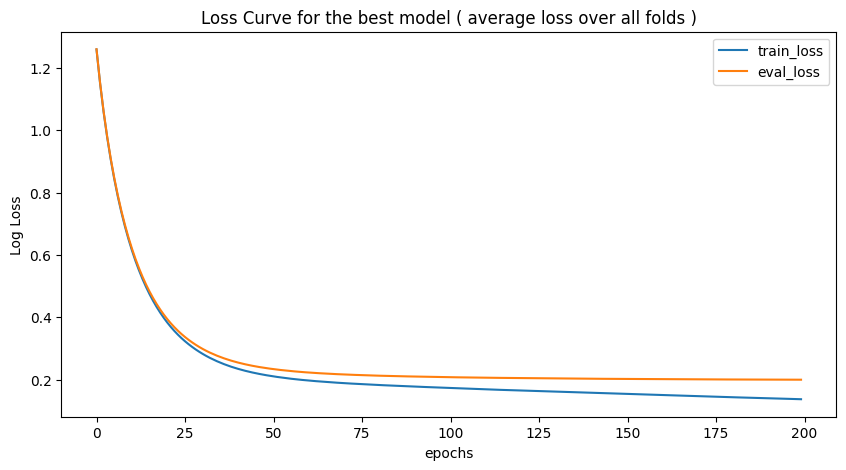

In [177]:
######################################################
#   Plotting the loss curve for the best model       #
######################################################

import matplotlib.pyplot as plt

def plot_loss_curve(best_eval_result):

    epochs = range(len(best_eval_result['validation_0']))

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, best_eval_result['validation_0'], label='train_loss')  # x: epochs, y: train_loss
    plt.plot(epochs, best_eval_result['validation_1'], label='eval_loss')  # x: epochs, y: eval_loss
    plt.title('Loss Curve for the best model ( average loss over all folds )')
    plt.xlabel('epochs')
    plt.ylabel('Log Loss')
    plt.legend()  # 범례 추가
    plt.show()

plot_loss_curve(final_best_eval_result)

## Testing on the test set and Reporting the classification result

In [284]:
######################################################
#  Testing on the test set and Reporting the result  #
######################################################

from sklearn.metrics import classification_report

def test_XGBoost_grid_result(dataset, model):
    _, test_idx = get_train_test_idx(dataset)
    X_test, y_test, test_groups = dataset.X[test_idx], dataset.y[test_idx], dataset.collection_ids[test_idx]
    # print(f'test on the groups: {np.unique(test_groups)} groups')

    # Compute the accuracy on the test set 
    y_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f'test accuracy: {test_accuracy:.6f}')

    print('-------------------------------------------------------')

    # Report the classification result 
    labels = range(len(np.unique(y_test)))
    class_names = ['heel strike', 'foot flat', 'heel off', 'toe off']
    classification_report_result = classification_report(y_test, y_pred, labels=labels, target_names=class_names)
    print(classification_report_result)

test_XGBoost_grid_result(dataset, final_best_model)

train groups: 1859, test groups: 465(20.0%), train size: 371290, test size: 93300
test accuracy: 0.917706
-------------------------------------------------------
              precision    recall  f1-score   support

 heel strike       0.68      0.60      0.64      1849
   foot flat       0.91      0.94      0.92     33777
    heel off       0.86      0.81      0.83     19754
     toe off       0.97      0.97      0.97     37920

    accuracy                           0.92     93300
   macro avg       0.85      0.83      0.84     93300
weighted avg       0.92      0.92      0.92     93300



## Testing on the individual test set ( per collection id )
This function tests the XGBoost model on individual collection_ids and generates accuracy and classification reports for each collection_id. 

**Report Files** 
- xgboost_final_report_per_collection_data.csv: the final report of the test data
- xgboost_final_report_per_collection_data_bad_performance.csv: the final report of the test data with the accuracy less than 0.80  
- saved in the `report` folder

**Report columns** 
- collection_id: the collection_id of the test data
- avg_accuracy: the average accuracy of the test data per collection_id
- data_size: the size of the test data per collection_id
- n_heel_strike: the number of heel strike in the test data per collection_id
- n_foot_flat: the number of foot flat in the test data per collection_id
- n_heel_off: the number of heel off in the test data per collection_id
- n_toe_off: the number of toe off in the test data per collection_id
    - data size per collection_id are added to analyse the relation between the data size and the model performance  

Columns below are from the classification report scikit-learn library 
- label: the class label of the test data
- precision: the precision of the test data
- recall: the recall of the test data
- f1-score: the f1-score of the test data
- support: the support of the test data

**Observation** 
- The model seems to work well on the test set: among 465 collection data, only 18 collection data have the accuracy less than 0.80. 
- Howver,
- The imbalance in the data does not seem to be a major factor for the model performance. 
    - also observed when training the model (See ```sample_weight``` parameter in the fit method. )
- The number of data per collection id does not seem to be a major factor for the model performance. 
- Further analysis seems to be needed to improve the model performance.

In [344]:
######################################################
#  Testing on the individual collection data         # 
#  Save the final report                             #
######################################################

from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import pandas as pd
import os

# reshape the classification report and convert to dataframe 
def convert_classification_reports_to_df(reports):
    rows = []
    for report in reports:
        collection_id = report['id']
        for label, metrics in report['result'].items():
            # use manually calculated accuracy, and only the major metrics
            if label in ['accuracy', 'macro avg', 'weighted avg']:
                continue
            row = {'collection_id': collection_id, 'label': label}
            row.update(metrics)
            rows.append(row)
    return pd.DataFrame(rows)

def test_report_XGBoost_per_collection_id(dataset, model):
    current_path = os.getcwd()
    report_path = os.path.join(current_path, 'report')
    os.makedirs(report_path, exist_ok=True)

    # Train-test split
    _, test_idx = get_train_test_idx(dataset)
    test_groups = dataset.collection_ids[test_idx]

    # Perform testing for each collection_id
    accuracy_results = {}
    classification_reports = []
    for collection_id in np.unique(test_groups):
        X_test_collection = dataset.X[dataset.collection_ids_df['collection_id'] == collection_id]
        y_test_collection = dataset.y[dataset.collection_ids_df['collection_id'] == collection_id]

        y_pred_collection = model.predict(X_test_collection)
        accuracy = accuracy_score(y_test_collection, y_pred_collection)
        accuracy_results[collection_id] = accuracy

        labels = range(len(np.unique(y_test_collection)))
        class_names = ['heel strike', 'foot flat', 'heel off', 'toe off']
        report = classification_report(y_test_collection, y_pred_collection, labels=labels, target_names=class_names, output_dict=True, zero_division=0)
        
        classification_report_dict = {}
        classification_report_dict['id'] = collection_id
        classification_report_dict['result'] = report
        classification_reports.append(classification_report_dict)

    accuracy_results_df = pd.DataFrame(list(accuracy_results.items()), columns=['collection_id', 'avg_accuracy']) 
    accuracy_results_df['data_size'] = accuracy_results_df['collection_id'].apply(lambda x: len(dataset.X_df[dataset.collection_ids_df['collection_id'] == x])) 
    accuracy_results_df['n_heel_strike'] = accuracy_results_df['collection_id'].apply(lambda x: len(dataset.y_df[(dataset.collection_ids_df['collection_id'] == x) & (dataset.y_df['phase'] == 0)]))
    accuracy_results_df['n_foot_flat'] = accuracy_results_df['collection_id'].apply(lambda x: len(dataset.y_df[(dataset.collection_ids_df['collection_id'] == x) & (dataset.y_df['phase'] == 1)]))
    accuracy_results_df['n_heel_off'] = accuracy_results_df['collection_id'].apply(lambda x: len(dataset.y_df[(dataset.collection_ids_df['collection_id'] == x) & (dataset.y_df['phase'] == 2)]))
    accuracy_results_df['n_toe_off'] = accuracy_results_df['collection_id'].apply(lambda x: len(dataset.y_df[(dataset.collection_ids_df['collection_id'] == x) & (dataset.y_df['phase'] == 3)]))

    classification_reports_df = convert_classification_reports_to_df(classification_reports)
    final_report = accuracy_results_df.merge(classification_reports_df, on='collection_id', how='left')
    bad_performance_report = final_report[final_report['avg_accuracy'] <= 0.80] 

    # Save the final report to the specified path
    final_report.to_csv(os.path.join(report_path, 'xgboost_final_report_per_collection_data.csv'))
    bad_performance_report.to_csv(os.path.join(report_path, 'xgboost_final_report_per_collection_data_bad_performance.csv')) 
    print(f'final_reports saved.')

    return final_report

final_report = test_report_XGBoost_per_collection_id(dataset, final_best_model)

train groups: 1859, test groups: 465(20.0%), train size: 371290, test size: 93300
final_reports saved.


In [351]:
final_report = pd.read_csv('report/xgboost_final_report_per_collection_data.csv')
print('number of collection ids:', final_report['collection_id'].nunique())
final_report = final_report.set_index(["collection_id", "avg_accuracy", "data_size", "n_heel_strike", "n_foot_flat", "n_heel_off", "n_toe_off", "label"])
final_report

number of collection ids: 465


Unnamed: 0  \
collection_id             avg_accuracy data_size n_heel_strike n_foot_flat n_heel_off n_toe_off label                     
0373xrf1eaJoc8IcE6Gc_7_R  0.948837     215       2             77          52         84        heel strike           0   
                                                                                                foot flat             1   
                                                                                                heel off              2   
                                                                                                toe off               3   
04SwmTFshylAIDUNCYTh_12_R 0.737991     229       2             135         12         80        heel strike           4   
...                                                                                                                 ...   
zmCkqhYTl03DYdauXAtc_7_R  0.936585     205       7             82          32         84        toe off            1855   
zmCkqhYTl03DYdauXAtc_8_L  0.840000     200       2             57          64         77        heel strike        1856   
                                                                                                foot flat          1857   
                                                                                                heel off           1858   
                                                                                                toe off            1859   

                                                                                                             precision  \
collection_id             avg_accuracy data_size n_heel_strike n_foot_flat n_heel_off n_toe_off label                    
0373xrf1eaJoc8IcE6Gc_7_R  0.948837     215       2             77          52         84        heel strike   0.500000   
                                                                                                foot flat     0.925926   
                                                                                                heel off      1.000000   
                                                                                                toe off       0.965517   
04SwmTFshylAIDUNCYTh_12_R 0.737991     229       2             135         12         80        heel strike   0.500000   
...                                                                                                                ...   
zmCkqhYTl03DYdauXAtc_7_R  0.936585     205       7             82          32         84        toe off       1.000000   
zmCkqhYTl03DYdauXAtc_8_L  0.840000     200       2             57          64         77        heel strike   0.400000   
                                                                                                foot flat     0.666667   
                                                                                                heel off      1.000000   
                                                                                                toe off       0.974684   

                                                                                                               recall  \
collection_id             avg_accuracy data_size n_heel_strike n_foot_flat n_heel_off n_toe_off label                   
0373xrf1eaJoc8IcE6Gc_7_R  0.948837     215       2             77          52         84        heel strike  1.000000   
                                                                                                foot flat    0.974026   
                                                                                                heel off     0.826923   
                                                                                                toe off      1.000000   
04SwmTFshylAIDUNCYTh_12_R 0.737991     229       2             135         12         80        heel strike  1.000000   
...                                                                        

In [349]:
bad_performance_report = pd.read_csv('report/xgboost_final_report_per_collection_data_bad_performance.csv')
print('number of collection ids:', bad_performance_report['collection_id'].nunique())
bad_performance_report = bad_performance_report.set_index(["collection_id", "avg_accuracy", "data_size", "n_heel_strike", "n_foot_flat", "n_heel_off", "n_toe_off", "label"])
bad_performance_report

number of collection ids: 18


Unnamed: 0  \
collection_id             avg_accuracy data_size n_heel_strike n_foot_flat n_heel_off n_toe_off label                     
04SwmTFshylAIDUNCYTh_12_R 0.737991     229       2             135         12         80        heel strike           4   
                                                                                                foot flat             5   
                                                                                                heel off              6   
                                                                                                toe off               7   
4ikPFuW5GnKXxIAtDvCg_13_R 0.777778     198       2             87          57         52        heel strike         156   
...                                                                                                                 ...   
xCKrVMuGR6iHMMeBTsQw_14_L 0.707207     222       7             130         9          76        toe off            1775   
zmCkqhYTl03DYdauXAtc_11_R 0.778894     199       13            41          68         77        heel strike        1844   
                                                                                                foot flat          1845   
                                                                                                heel off           1846   
                                                                                                toe off            1847   

                                                                                                             precision  \
collection_id             avg_accuracy data_size n_heel_strike n_foot_flat n_heel_off n_toe_off label                    
04SwmTFshylAIDUNCYTh_12_R 0.737991     229       2             135         12         80        heel strike   0.500000   
                                                                                                foot flat     1.000000   
                                                                                                heel off      0.020833   
                                                                                                toe off       0.879121   
4ikPFuW5GnKXxIAtDvCg_13_R 0.777778     198       2             87          57         52        heel strike   0.500000   
...                                                                                                                ...   
xCKrVMuGR6iHMMeBTsQw_14_L 0.707207     222       7             130         9          76        toe off       0.808511   
zmCkqhYTl03DYdauXAtc_11_R 0.778894     199       13            41          68         77        heel strike   1.000000   
                                                                                                foot flat     0.506173   
                                                                                                heel off      0.902439   
                                                                                                toe off       1.000000   

                                                                                                               recall  \
collection_id             avg_accuracy data_size n_heel_strike n_foot_flat n_heel_off n_toe_off label                   
04SwmTFshylAIDUNCYTh_12_R 0.737991     229       2             135         12         80        heel strike  1.000000   
                                                                                                foot flat    0.637037   
                                                                                                heel off     0.083333   
                                                                                                toe off      1.000000   
4ikPFuW5GnKXxIAtDvCg_13_R 0.777778     198       2             87          57         52        heel strike  0.500000   
...                                                                        